In [176]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.despine()
from dateutil import parser
import calendar

# snowdepth vs cumulative snowfall

<Figure size 432x288 with 0 Axes>

In [177]:
weather_df = pd.read_csv('~/Downloads/1643302.csv')

city_df = pd.read_csv('~/Downloads/csv-zusammenfuehren.de_7gr2scwy.csv')
city_df["AMOUNT"]=city_df["AMOUNT"].str.replace(',','')
city_df["AMOUNT"]=pd.to_numeric(city_df["AMOUNT"])
m=[]
y=[]
for i in city_df['EFF DATE']:
    d=parser.parse(i)
    m.append(d.strftime("%m"))
    y.append(d.strftime("%Y"))
city_df['MONTH'] = m
city_df['YEAR'] = y
c_df = city_df[['ORG', 'OBJECT', 'DESCRIPTION', 'YEAR', 'MONTH', 'AMOUNT', 'EFF DATE']]
c_df = c_df.drop(c_df[c_df.YEAR == '2019'].index)
#c_df = c_df.drop(c_df[(c_df.MONTH == '06') | (c_df.MONTH == '07') | (c_df.MONTH == '08') | (c_df.MONTH == '09')].index)

In [196]:
# cleaning the data of NAN values
# this removes ~96% of the data (snowfall and snow depth is not recorded hourly)
# data internally uses T to represent no snowfall, we will remove that as well

weather_df['DailySnowfall'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowfall'], inplace=True)

weather_df['DailySnowDepth'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowDepth'], inplace=True)

# converting the columns to numeric from object type

weather_df["DailySnowfall"]=pd.to_numeric(weather_df["DailySnowfall"], errors='ignore')
weather_df["DailySnowDepth"]=pd.to_numeric(weather_df["DailySnowDepth"], errors='ignore')

# slicing date to add a new column year
weather_df['YEAR']=weather_df['DATE'].str.slice(start=0, stop=4)
weather_df["YEAR"]=pd.to_numeric(weather_df["YEAR"], errors='ignore')

weather_df['MONTH'] = weather_df['DATE'].str.slice(start=5, stop=7)
for i in weather_df['MONTH']:
    if len(i) == 1:
        i="0"+i
#weather_df["MONTH"]=pd.to_numeric(weather_df["MONTH"], errors='ignore')
weather_df['MONTH']
w_df = weather_df[['DailySnowfall', "DailySnowDepth", "MONTH", "YEAR", "DATE"]]
w_df = w_df.drop(w_df[w_df.YEAR == 2019].index)
#w_df = w_df.drop(w_df[(w_df.MONTH == 6) | (w_df.MONTH == 7) | (w_df.MONTH == 8) | (w_df.MONTH == 9)].index)
#w_df
#winter_df = weather_df.loc[(weather_df['MONTH'] == '03') | (weather_df['MONTH'] == '02') | (weather_df['MONTH'] == '01')]
#winter_df

#concatenated=pd.concat([w_df.assign(dataset="w_df"), c_df.assign(dataset="c_df")], sort=False)
#concatenated

In [179]:
# lets look at the shape of the distribution of both snowfall and snow depth
#val = weather_df['DailySnowDepth'].values
#sns.distplot(val, rug=True, color="b");
#weather_df['DailySnowDepth'].values

In [180]:
# scatterplot of snowfall vs snowdepth
# histogram on the axes
# can see that there is a wide variation of snow depths that correspond to amount of daily snowfall
# there is unlikely to be much correlation

#sns.jointplot(x="DailySnowfall", y="DailySnowDepth", height=20, data=weather_df, kind="reg");

In [181]:
# another cool way to visualize this data
# we can see the distribution seems mostly random

#sns.pairplot(weather_df, vars=["DailySnowfall", "DailySnowDepth"], hue="YEAR", height=5);

In [182]:
# just to be sure there isn't much correlation, let us look at a scatterplot of daily snowfall vs snow depth
# we can see that there is a lot of variation in this data
# 2019 does however seem to have a lot of variation which suggests scattered snowfall

#ax = sns.scatterplot(x="DailySnowfall", y="DailySnowDepth", data=w_df, hue='YEAR')
#plt;

In [183]:
# thinking of different ways to visualize distribution data
# snowfall depth and daily snowfall placed in hexbins
# intensity of color corresponds to frequency
# 2019 is most random due to erratic snowfall
# seems like in 2019, snow depth accumulated due to continuous snowfall
# snowfall seemeds to be less on a single day and more dispersed in other years

'''def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True, n_colors=100)
    plt.hexbin(x, y, gridsize=12, cmap=cmap, **kwargs)

with sns.axes_style("white"):
    g = sns.FacetGrid(w_df, hue="YEAR", col="YEAR", height=4)
g.map(hexbin, "DailySnowfall", "DailySnowDepth", extent=[0,9, 0,9]);'''

'def hexbin(x, y, color, **kwargs):\n    cmap = sns.light_palette(color, as_cmap=True, n_colors=100)\n    plt.hexbin(x, y, gridsize=12, cmap=cmap, **kwargs)\n\nwith sns.axes_style("white"):\n    g = sns.FacetGrid(w_df, hue="YEAR", col="YEAR", height=4)\ng.map(hexbin, "DailySnowfall", "DailySnowDepth", extent=[0,9, 0,9]);'

37.8

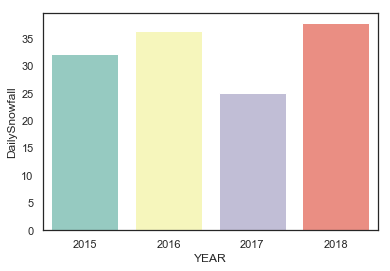

In [197]:
# lets plot the average daily snowfall for each year
# this will help us determine which years the city had to plow more intensely
# (as a high daily snowfall leads to more accumulated snow after the previous plowing)

sns.barplot(x='YEAR', y='DailySnowfall', data=w_df, palette="Set3", estimator=sum, ci=None);
a = w_df.loc[w_df['YEAR'] == 2018]
a['DailySnowfall'].sum()

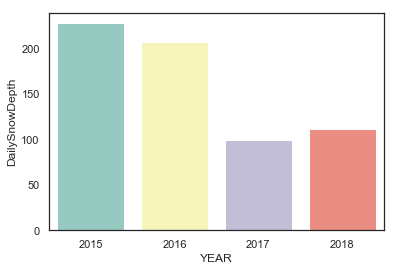

In [198]:
# lets plot the average daily snowdepth for each year
# this will also help us determine which years the city had to plow more intensely
# hopefully 2019 should be the highest again as it should have the highest snowdepth due to rapid bursts of snowfall

sns.barplot(x='YEAR', y='DailySnowDepth', data=w_df, palette="Set3", estimator=sum, ci=None);

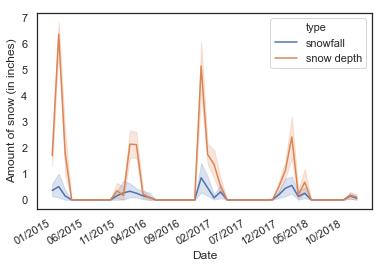

In [199]:
w_df['Date'] = w_df['MONTH'].astype(str)+'/'+w_df['YEAR'].astype(str)
a = w_df[['DailySnowfall', 'Date']]
a=a.rename(columns={'DailySnowfall': 'amount'})
a['type'] = 'snowfall'
a

b = w_df[['DailySnowDepth', 'Date']]
b=b.rename(columns={'DailySnowDepth': 'amount'})
b['type'] = 'snow depth'
b

ts = pd.concat([a,b])
ts

fig, ax = plt.subplots()
x=sns.lineplot(x='Date', y='amount', hue='type', data=ts, legend='full', sort=False, ci=90)
for label in x.xaxis.get_ticklabels():
    label.set_visible(False)
for label in x.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)
ax.set(ylabel='Amount of snow (in inches)')
fig.autofmt_xdate()

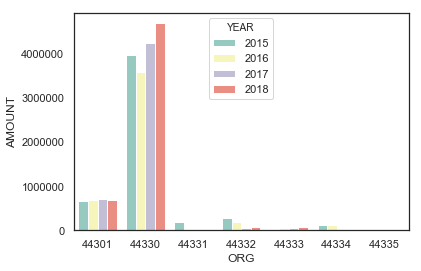

In [200]:
# plotting distribution of city data
# want to see if there is a large deviation of amount spent in transactions by a department
# we can clearly see that there is a large spread for org 44330 (Plowing)
sns.barplot(x="ORG", y="AMOUNT", hue="YEAR", data=c_df, estimator=sum, ci=None, palette="Set3");

In [188]:
#sns.barplot(x="ORG", y="AMOUNT", hue="YEAR", data=c_df, col='ORG', estimator=sum);

In [189]:
city_df['AMOUNT'].sum()
#plow_df = city_df.loc[city_df['ORG'] == 44330]
#plow_df['AMOUNT'].sum()

22521211.27

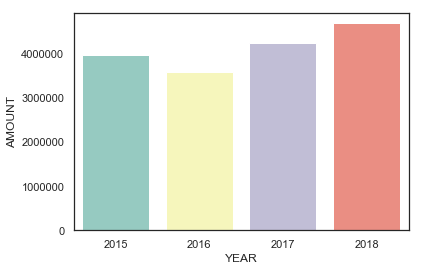

In [201]:
# lets focus closer on this department
# is there a large variation per year?
# we are plotting the average value of each plowing transaction per year
# the lines correspond to error bars that give us some insight about the uncertainity regarding each value

plow_df = c_df.loc[c_df['ORG'] == 44330]
sns.barplot(x='YEAR', y='AMOUNT', data=plow_df, palette="Set3", estimator=sum, ci=None);

# this is good since 2019 is the highest
# remember that 2019 had the highest average snowfall and snowdepth as well
# thus there seems to be a correlation between amount spent on plowing and snowfall

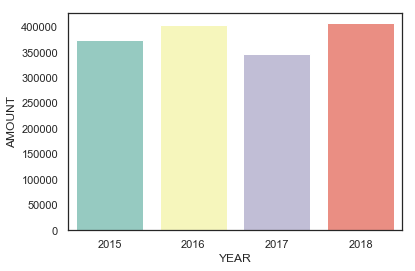

In [202]:
# now that we have narrowed down the organization to 44330 (which corresponds to Snow Plowing), lets try and get a sense
# of how funds are distributed within the organization
# a cursory glance at the objects within the organization directed my attention to the snow removal object (54260)
# the amount of money spent by this object should ideally follow the same correlation we observed in the previous chart

snow_plow_df = plow_df.loc[plow_df['OBJECT'] == 51310]
sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3", estimator=sum, ci=None);
#a = snow_plow_df.loc[snow_plow_df['YEAR'] == '2018']
#a['AMOUNT'].sum()

# clearly our assumption was wrong as 2015 had the highest amount instead of 2019

In [136]:
# lets try another object. Snow Supplies (53240) seems like a good candidate.
# The amount of snowfall should ideally correlate to the amount the city spends on supplies (salt, sand, etc.)

#snow_plow_df = plow_df.loc[(plow_df['OBJECT'] == 57141) | (plow_df['OBJECT'] == 53240) | (plow_df['OBJECT'] == 51110) | (plow_df['OBJECT'] == 51310)]
#sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3", estimator=sum);

# again, this doesn't seem to be correlated at all
# a possible explanation for this might be that the city stockpiles supplies in advance?
# this would make sense as they would be prepared well in advance for winter

In [137]:
# lets try permanent wages next.

#snow_plow_df = plow_df.loc[plow_df['OBJECT'] == 51110]
#sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3", estimator=sum);

# finally we get a clear correlation. There is a big jump from 2018 to 2019 (almost $20k in spending)
# this is definitely statistically significant as the data for January only has data up till February.
# 2 months of January 2019 resulted in more spending by the city on permanent wages than any other year in our dataset.

In [246]:
# now that we know that we should focus on wages, I was planning on looking at hourly wages 
# however the last data entry for hourly wages was in 2018 so I assume that it doesn't factor in the analysis

#sns.countplot(x='YEAR', data=snow_plow_df, palette="Set3");
wr_df = w_df
wr_df['Date'] = w_df['YEAR'].astype(str)+'/'+w_df['MONTH'].astype(str)
wr_df=wr_df.groupby(['Date'])['DailySnowfall'].sum().reset_index()
cr_df =c_df
cr_df['Date'] = c_df['YEAR'].astype(str)+'/'+c_df['MONTH'].astype(str)
cr_df = cr_df.loc[cr_df['OBJECT'] == 51310]
cr_df=cr_df.groupby(['Date'])['AMOUNT'].sum().reset_index()

r_df = pd.merge(wr_df, cr_df, on='Date')
r_df['MONTH'] = r_df['Date'].str.slice(start=5)
r_df=r_df.rename(columns={'AMOUNT': 'Amount spent on hourly overtime wages', 'DailySnowfall': 'Amount of snow (in inches)'})
r_df
#print (r_df['DailySnowfall'].to_string(index=False))
# 2019 has 5 entries yet already has more spending on permanent wages than any other year

,Date,Amount of snow (in inches),Amount spent on hourly overtime wages,MONTH
0,2015/01,7.2,96807.89,01
1,2015/02,10.7,171841.03,02
2,2015/03,3.8,45536.79,03
3,2015/04,0.0,10553.58,04
4,2015/05,0.0,2614.22,05
5,2015/06,0.0,2912.34,06
6,2015/07,0.0,919.48,07
7,2015/08,0.0,2119.22,08
8,2015/09,0.0,2342.10,09
9,2015/10,0.0,1008.45,10


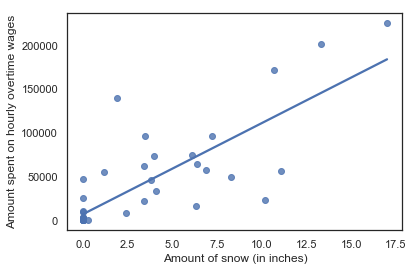

In [247]:
#d = {'snowfall': [32.2, 36.4, 25.1, 37.8], 'spending': [373190, 403084, 347506, 407097], 'year': [2015, 2016, 2017, 2018]}
#df = pd.DataFrame(data=d)
#sns.regplot(x='snowfall', y='spending', data=df, scatter_kws={"s":80}, order=2, ci=None, truncate=True)
sns.regplot(x='Amount of snow (in inches)', y='Amount spent on hourly overtime wages', data=r_df, ci=None, truncate=True)